In [7]:
import networkx as nx
import numpy as np
import graph_generator as gg
import graph_visualiser as gv
import importlib

In [ ]:
importlib.reload(gg)
importlib.reload(gv)

## 3. Electrical circuit analysis

#### Function for finding simple cycles.

Finding simple cycles is necessary to utilize Kirchhoff's second law when solving circuits. The algorithm begins by finding any spanning tree of the graph, then iterates over all edges not present in the spanning tree. Such an edge always adds a cycle, which can be found by locating the first common ancestor of the vertices at the ends of the edge.

In [9]:
from collections import deque
from math import inf

def find_cycle_basis(
        graph: nx.Graph, 
        s: int, 
        t: int
) -> list[list[int]]:
    """
        Returns simple cycles in graph 
    """
    n = graph.number_of_nodes()
    g = [[] for _ in range(n)]
    for i in range(n):
        for x in graph.neighbors(i):
            g[i].append(x)

    g[s].remove(t)
    g[t].remove(s)

    parent = [None for _ in range(n)]
    dist = [inf for _ in range(n)]

    d = deque()
    d.append(s)
    dist[s] = 0
    used_edges = set()
    while d:
        v = d.popleft()
        for x in g[v]:
            if dist[x] == inf:
                parent[x] = v
                dist[x] = dist[v] + 1
                used_edges.add((v, x))
                used_edges.add((x, v))
                d.append(x)

    cycles = []
    for a, b in graph.edges:
        if (a, b) not in used_edges:
            ptr_a = a
            ptr_b = b
            count_a = dist[a]
            count_b = dist[b]
            nodes_a = []
            nodes_b = []
            if count_a < count_b:
                while count_b != count_a:
                    nodes_b.append(ptr_b)
                    ptr_b = parent[ptr_b]
                    count_b -= 1
            elif count_a > count_b:
                ptr_a = a
                while count_b != count_a:
                    nodes_a.append(ptr_a)
                    ptr_a = parent[ptr_a]
                    count_a -= 1
            while ptr_b != ptr_a:
                nodes_b.append(ptr_b)
                nodes_a.append(ptr_a)
                ptr_a = parent[ptr_a]
                ptr_b = parent[ptr_b]

            nodes_a.append(ptr_b)
            cycles.append(nodes_a + nodes_b[::-1])
    return cycles

#### Solving electrical circuit using Kirchoff's laws

This function finds the currents in the different parts of the circuit using Kirchhoff's laws. It takes as input an object of type nx.Graph(), as well as a pair of vertices s and t between which an electromotive force e is applied. It modifies the current value on each edge of the graph.

It assumes that the conventional direction of the current always leads from the vertex with a smaller index to the vertex with a larger index (vertices of the graph are described by consecutive natural numbers starting from zero).

To determine simple cycles, it uses the previously described find_cycle_basis function. It solves the system of equations using numpy.linalg.solve(), but since this function does not solve overdetermined systems of equations, it first left-multiplies the matrix equation by the transpose of the system matrix.

In [10]:
def kirchoff(g: nx.Graph, s: int, t: int, e: float) -> None:
    
    def add_sum_component(v1: int, v2: int) -> None:
        edge = g[v1][v2]['edge']
        if (v1, v2) == (s, t) or (v1, v2) == (t, s):
            if v1 < v2:
                B[eq_no] -= e
            else:
                B[eq_no] += e
        else:
            if v1 < v2:
                A[eq_no][edge.index] += edge.resistance
            else:
                A[eq_no][edge.index] -= edge.resistance

    n = g.number_of_nodes()
    m = g.number_of_edges()

    cycle_basis = find_cycle_basis(g, s, t)
    no_of_eq = n + len(cycle_basis)
    A = np.zeros((no_of_eq, m))
    B = np.zeros(no_of_eq)

    eq_no = 0
    for cycle in cycle_basis:
        for i in range(1, len(cycle)):
            add_sum_component(cycle[i-1], cycle[i])
        add_sum_component(cycle[-1], cycle[0])
        eq_no += 1

    for v in range(n):
        for neighbor in g.neighbors(v):
            edge = g[v][neighbor]['edge']
            if v < neighbor:
                A[eq_no][edge.index] += 1
            else:
                A[eq_no][edge.index] -= 1
        eq_no += 1

    transposed = A.T
    ans = np.linalg.solve(np.matmul(transposed, A), np.matmul(transposed, B))
    for a, b in g.edges:
        edge = g[a][b]['edge']
        edge.current = ans[edge.index]

#### Finding currents using the nodal analysis method.

The function takes the same arguments as kirchoff() and similarly returns nothing; it only modifies the given graph.

I determine the conventional direction of the current in the same way as in Kirchoff's method. I set the potential to 0 at vertex s. Then vertex t must have a potential of E.

The resulting system matrix is square, so it can be solved using np.linalg.solve. Currents are found by dividing the potential difference on a given edge by its resistance.

In [11]:
def nodal_potentials(g: nx.Graph, s: int, t: int, e: float) -> None:
    
    n = g.number_of_nodes()
    A = np.zeros((n, n))
    B = np.zeros(n)
    A[s][s] = 1
    B[s] = e
    A[t][t] = 1
    B[t] = 0

    for v in range(n):
        if v != s and v != t:
            for neighbor in g.neighbors(v):
                edge = g[v][neighbor]['edge']
                A[v][v] += 1/edge.resistance
                A[v][neighbor] -= 1/edge.resistance

    potentials = np.linalg.solve(A, B)
    for a, b in g.edges:
        edge = g[a][b]['edge']
        if a < b:
            edge.current = (potentials[a] - potentials[b]) / edge.resistance
        else:
            edge.current = (potentials[b] - potentials[a]) / edge.resistance

#### Generating, loading, and drawing graphs

You can load a pre-existing graph by specifying the file name from the 'saved_graphs' folder.

The load_graph function from the graph_generator module loads a graph and returns the graph (an object of type nx.Graph), the vertices between which an electromotive force is applied, and the value of this force.

Graph drawing is done through the graph_visualiser module.

The draw_with_resistance function draws an undirected graph, with the edge on which the voltage is applied shown in blue. The draw_with_current function draws a directed graph, with edges indicating the direction of the current.

The size_param parameter determines the dimensions of the plot generated by matplotlib.

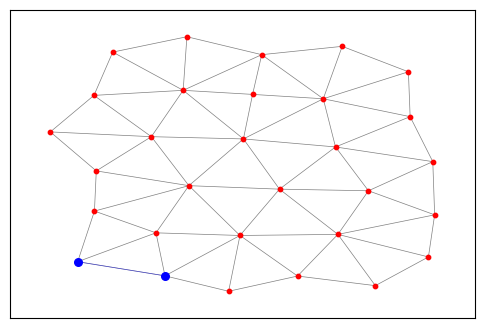

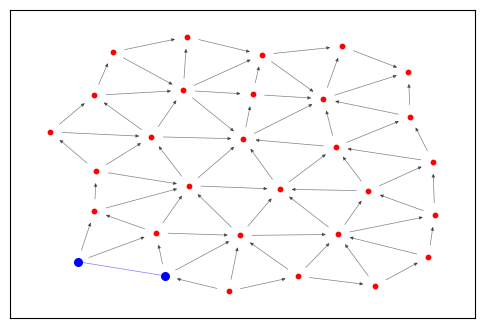

In [12]:
G, source, target, E = gg.load_graph("triangulation_small")
gv.draw_with_resistance(G, source, target, E, size_param=(6, 4))
gv.draw_with_current(G, source, target, E, size_param=(6, 4))

Both functions can be passed a 'small' flag. If small == True, additional information will be shown: resistance values on each edge (in undirected graphs) or current values (in directed graphs), as well as the voltage value. The parameter is named 'small' because for large graphs, labels become unreadable.

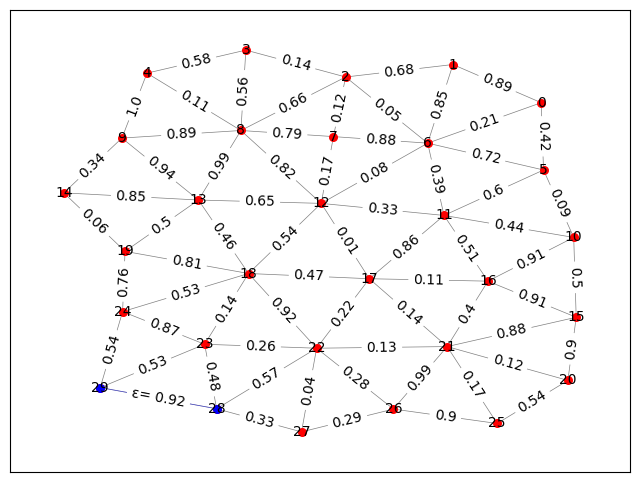

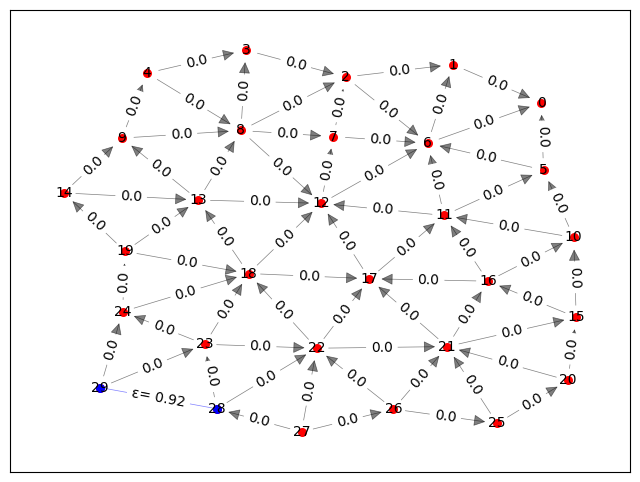

In [13]:
gv.draw_with_resistance(G, source, target, E, small=True, size_param=(8, 6))
gv.draw_with_current(G, source, target, E, small=True, size_param=(8, 6))

Initially, the current values are zero since no function solving the system has been executed yet

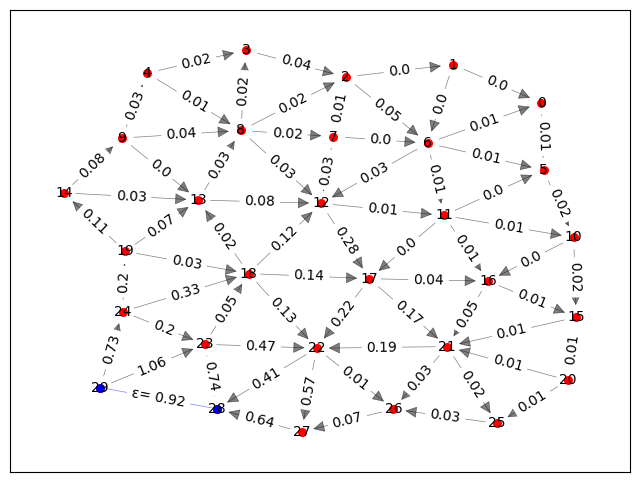

In [14]:
kirchoff(G, source, target, E)
gv.draw_with_current(G, source, target, E, small=True, size_param=(8, 6))

The nodal_potentials function takes a graph with the current values already filled in (to avoid making copies), but these values are then overwritten with the values obtained using the nodal analysis method.

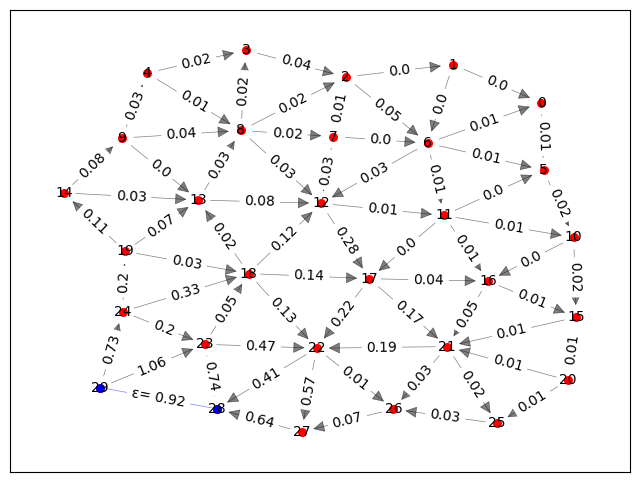

In [15]:
nodal_potentials(G, source, target, E)
gv.draw_with_current(G, source, target, E, small=True, size_param=(8, 6))


I round the displayed current values to two decimal places, so discrepancies with Kirchhoff's first law may appear on the drawing as a result.


In the graph_generator module, there are also functions available for randomly generating graphs of different types (returning the same quadruple as load_graph).

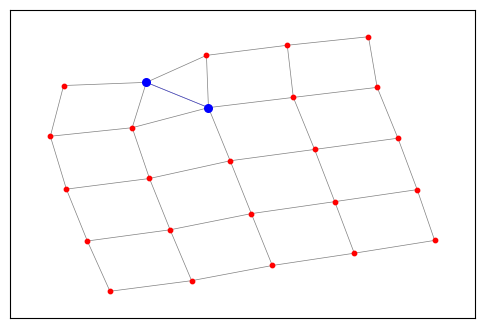

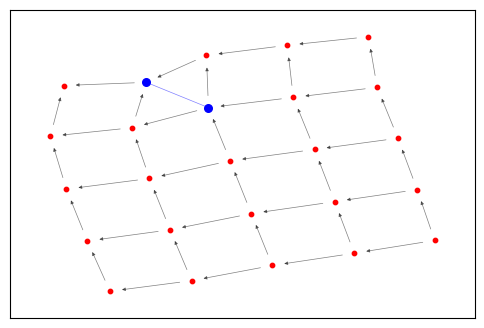

In [16]:
G, source, target, E = gg.generate_2d_mesh(5, 5)
gv.draw_with_resistance(G, source, target, E, size_param=(6, 4))
gv.draw_with_current(G, source, target, E, size_param=(6, 4))

#### Algorithms tests

In [17]:
def check_currents(g: nx.Graph, s: int, t: int) -> bool:
    """
        Checking if the sum of current flowing into vertex is 0
    """
    eps = pow(10, -9)
    for v in range(g.number_of_nodes()):
        if v != s and v != t:
            current_sum = 0
            for neighbor in g.neighbors(v):
                if v < neighbor:
                    current_sum += g[v][neighbor]['edge'].current
                else:
                    current_sum -= g[v][neighbor]['edge'].current
            if abs(current_sum) > eps:
                return False
    return True

In [18]:
def save_current_values(g, s, t):
    current_values = []
    for a, b in g.edges:
        if (a, b) not in [(s, t), (t, s)]:
            current_values.append(g[a][b]['edge'].current)
    return current_values

In [19]:
def cmp_vectors(v1, v2):
    """
        Compares two vectors
    """
    eps = pow(10, -9)
    for a, b in zip(v1, v2):
        if abs(a - b) > eps:
            return False
    return True

#### Checking correctness for several example graphs

-------------
Graph name: bridge_graph_1
Number of vertices: 35
Number of edges: 103


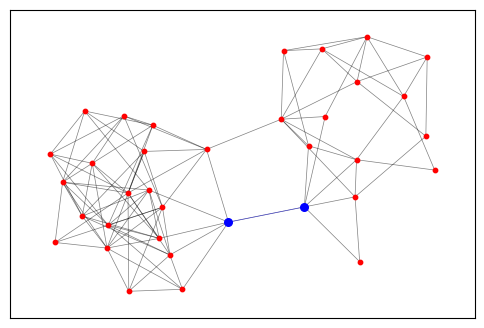

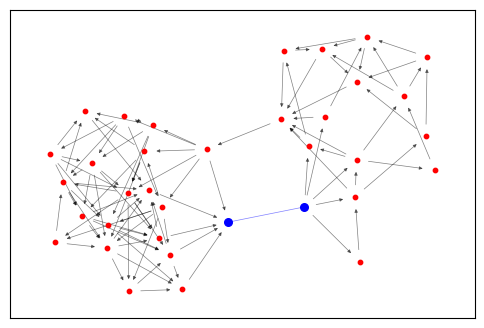

Compare both algorithms results bridge_graph_1: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: bridge_graph_2
Number of vertices: 13
Number of edges: 21


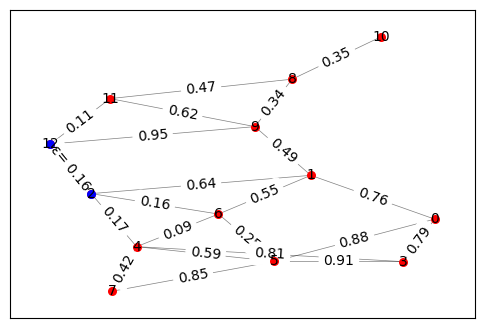

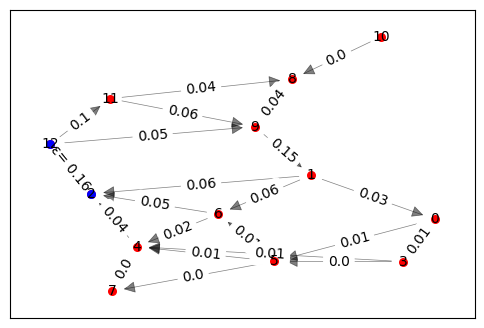

Compare both algorithms results bridge_graph_2: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: cubic_large
Number of vertices: 200
Number of edges: 300


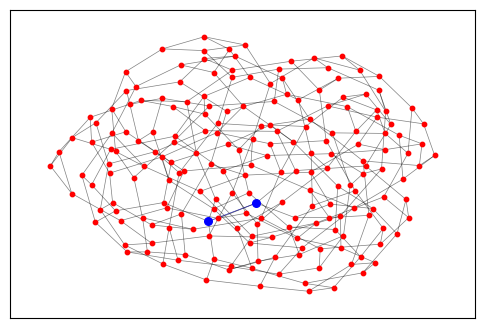

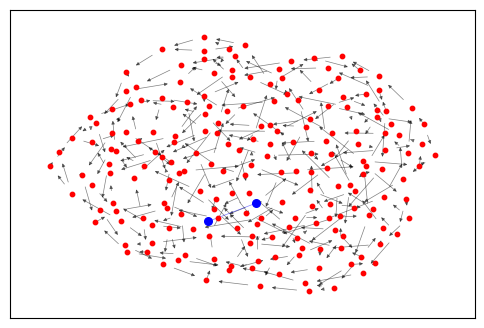

Compare both algorithms results cubic_large: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: cubic_small
Number of vertices: 26
Number of edges: 39


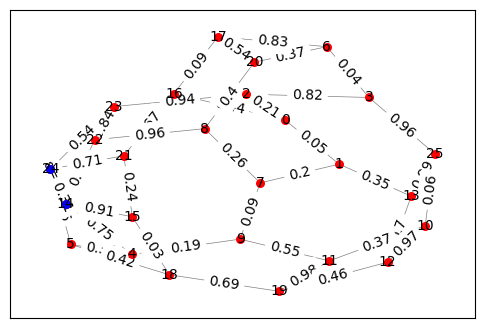

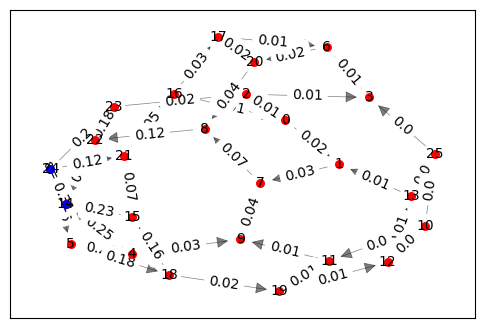

Compare both algorithms results cubic_small: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: erdos_renyi_large
Number of vertices: 200
Number of edges: 394


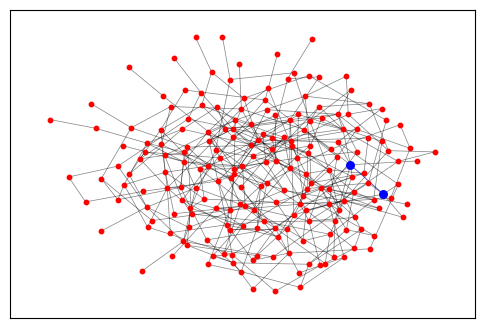

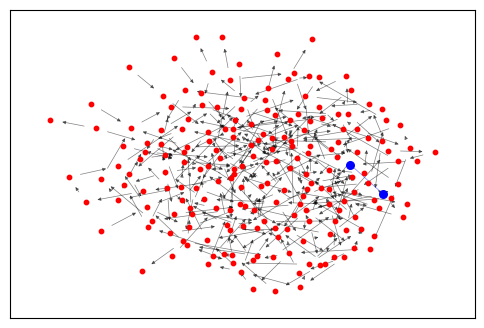

Compare both algorithms results erdos_renyi_large: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: erdos_renyi_small
Number of vertices: 15
Number of edges: 21


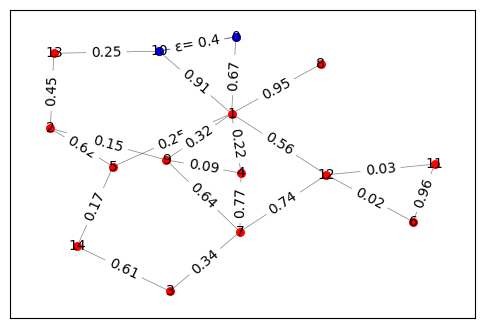

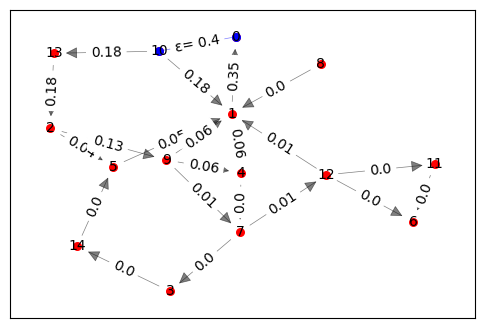

Compare both algorithms results erdos_renyi_small: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: rectangular_mesh_large
Number of vertices: 400
Number of edges: 760


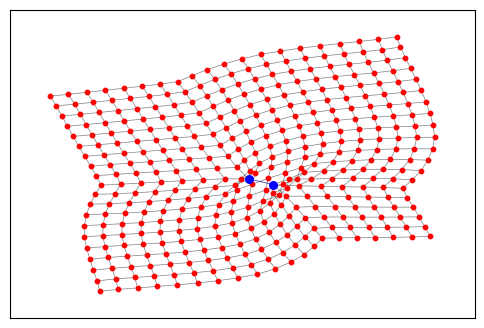

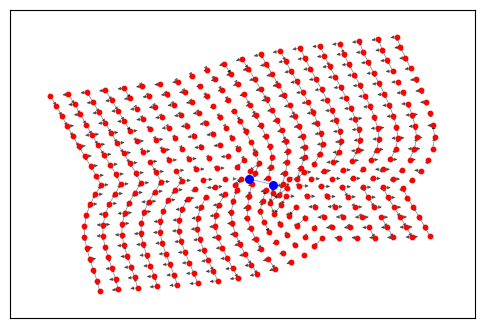

Compare both algorithms results rectangular_mesh_large: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: rectangular_mesh_small
Number of vertices: 25
Number of edges: 40


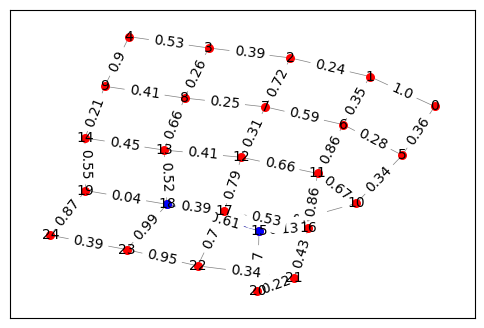

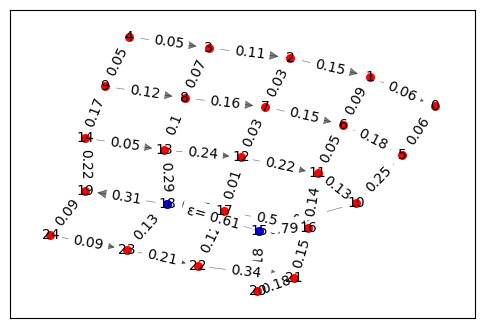

Compare both algorithms results rectangular_mesh_small: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: smaller_world
Number of vertices: 20
Number of edges: 60


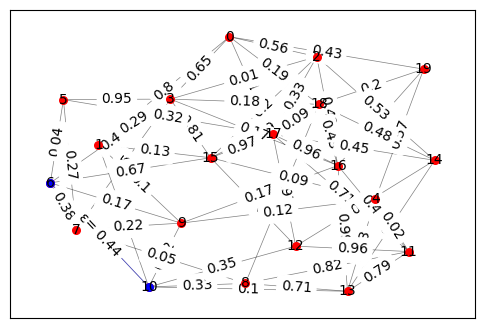

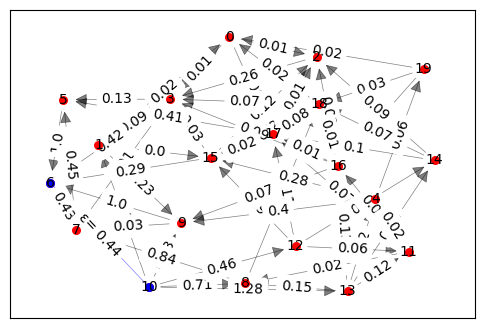

Compare both algorithms results smaller_world: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: small_world
Number of vertices: 100
Number of edges: 1000


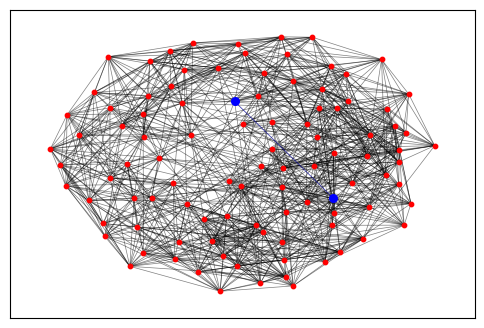

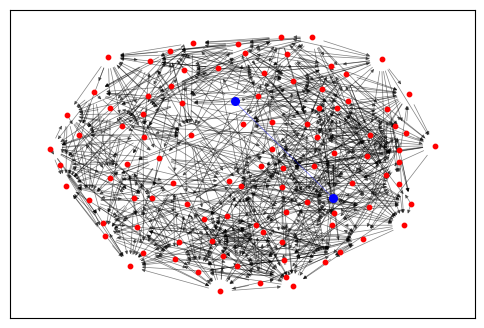

Compare both algorithms results small_world: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: triangulation_large
Number of vertices: 750
Number of edges: 2141


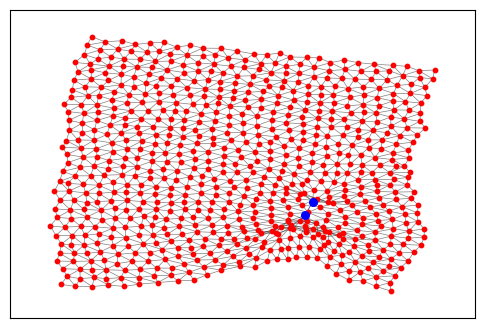

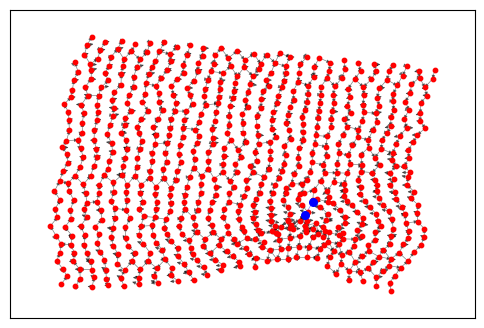

Compare both algorithms results triangulation_large: True
Verification of compliance with Kirchhoff's first law : True



-------------
Graph name: triangulation_small
Number of vertices: 30
Number of edges: 68


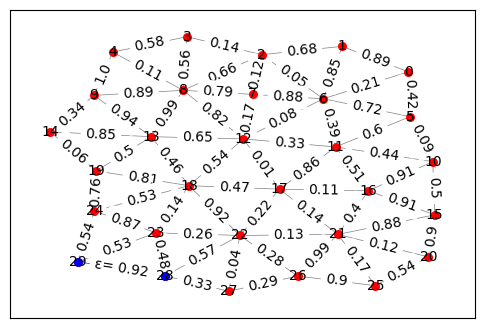

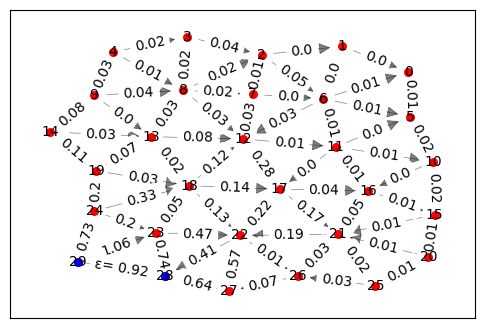

Compare both algorithms results triangulation_small: True
Verification of compliance with Kirchhoff's first law : True





In [20]:
from os.path import isfile, join
from os import listdir

file_names = [f for f in listdir('saved_graphs') if isfile(join('saved_graphs', f))]
for f_name in file_names:
    print("-------------")
    G, source, target, E = gg.load_graph(f_name)
    print(f"Graph name: {f_name}")
    print(f"Number of vertices: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges() - 1}")
    small = True if G.number_of_nodes() <= 30 else False
    gv.draw_with_resistance(G, source, target, E, small=small, size_param=(6, 4))
    kirchoff(G, source, target, E)
    vector1 = save_current_values(G, source, target)
    nodal_potentials(G, source, target, E)
    vector2 = save_current_values(G, source, target)
    gv.draw_with_current(G, source, target, E, small=small, size_param=(6, 4))
    print(f"Compare both algorithms results {f_name}: {cmp_vectors(vector1, vector2)}")
    print(f"Verification of compliance with Kirchhoff's first law : {check_currents(G, source, target)}")
    print("\n\n")

For precision up to 9 decimal places, the values returned by both algorithms were similar for all graphs.
For precision up to 12 decimal places, the current values did not fully match for the 'small world' and 'large_traingulation' graphs. However, this is a very small discrepancy, so it can be inferred that both algorithms were implemented correctly.

#### Conclusions
Both algorithms return correct results, but in my opinion, the nodal analysis method is much better. It is simpler to implement than Kirchhoff's laws and does not require finding cycle bases. Its main advantage, however, is computational complexity. The most costly step in any algorithm is solving the system of equations. In the nodal analysis method, we end up with a square system of equations V x V (V is the number of nodes in the circuit) because we need to calculate the potential for each node. With Kirchhoff's laws, we end up with a system of order E x V, because we treat current values on edges as variables and each equation might involve some vertex. For dense graphs, Kirchhoff's method becomes completely inefficient.
